In [53]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import sklearn
from sklearn.feature_extraction.text import CountVectorizer

import string

import nltk

from operator import itemgetter

import pandas as pd

import datetime

import seaborn as sns

/Users/SteveChadwick/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('appstore_games.csv', encoding = "ISO-8859-1")

In [3]:
description = data["Description"]
keywords = []

#remove capital letters and punctuation
for i in range(len(description)):
    s = description[i].lower().replace("\\n",' ').translate(str.maketrans('', '', string.punctuation)).split()
    keywords.append(s)


In [4]:
flat_keywords = [item for sublist in keywords for item in sublist]

#remove numbers and words containing numbers
flat_keywords = [x for x in flat_keywords if not any(c.isdigit() for c in x)]

keywords_set = set(flat_keywords)
flat_keywords[0:10]

['join', 'over', 'of', 'our', 'fans', 'and', 'download', 'one', 'of', 'our']

In [5]:
def most_common_by_POS(word_list, POS, output_len):
    """This function takes a list of non-unique words and a part of speach tag (e.i. noun "N" or adjective "J")
    and returns a list of tuples with the most common words and their number of appearences in the word_list."""
   
    keyword_set = set(word_list)
    keywords_str = " ".join(keywords_set)
    selected_POS = [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(keywords_str)) if pos[0] == POS]
    
    selected_set = set(selected_POS)
    
    word_count = {}
    for i in word_list:
        if i in selected_set:
            word_count[i] = word_count.get(i, 0 ) + 1
    
    output_list = sorted(list(word_count.items()), key=itemgetter(1), reverse=True)
    
    if len(selected_POS) < output_len:
        return output_list
    else:
        return output_list[:output_len]
            
        
    

Here we clean the data to remove all stop words and words containing numbers. We also make all words lower case and remove punctuation. This creates a "bag of words" for each description.

In [6]:
cleaned_descriptions = [i.lower().replace("\\n",' ').translate 
                        (str.maketrans('', '', string.punctuation)) for i in description]
no_digits = []
for doc in cleaned_descriptions:
    no_digits.append(' '.join(word for word in doc.split() if not any(c.isdigit() for c in word)))

stop_words = set(nltk.corpus.stopwords.words('English'))

clean = []

for doc in no_digits:
    cleaned_doc = ''
    for word in doc.split():
        if word not in stop_words:
            cleaned_doc += ' ' + word
    clean.append(cleaned_doc)

bow = clean

In [7]:
bow_dict = { ID: [doc] for (ID ,doc) in list(zip(data["ID"], bow))}
bow_df = pd.DataFrame.from_dict(bow_dict).transpose()
bow_df.columns = ["Description"]
bow_df = bow_df.sort_index()
#bow_df

Here we use sklearn to create a document term matrix in a pandas dataframe.

In [8]:
vec = CountVectorizer()
count_array = vec.fit_transform(bow_df.Description)
doc_term = pd.DataFrame(count_array.toarray(), columns=vec.get_feature_names())
doc_term.index = bow_df.index

In [9]:
term_doc = doc_term.transpose()
term_doc.head()

,284921427,284926400,284946595,285755462,285831220,286210009,286313771,286363959,286566987,286682679,...,1474600038,1474601590,1474605652,1474608803,1474611467,1474626442,1474919257,1474962324,1474963671,1475076711
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaaaaaaaaaaaaaaaaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def count_unique(ID, term_doc):
    """This function takes document IDs and the term document matrix as arguments and returns the number
    of unique non-stopwords."""
    unique_count = []

    for i in ID:
        unique_count.append(len(np.unique(term_doc[i])) - 1)
    return np.asarray(unique_count)
unique_count = count_unique(data["ID"], term_doc)

In [57]:
unique_count.max(), unique_count.std() ,unique_count.mean()

(17, 2.0493042198805793, 4.0402775327806202)

In [12]:
keywords_str = 'the cat enjoyed the warmer weather.'
selected_POS = [(word, pos) for (word, pos) in nltk.pos_tag(nltk.word_tokenize(keywords_str))]
selected_POS

[('the', 'DT'),
 ('cat', 'NN'),
 ('enjoyed', 'VBD'),
 ('the', 'DT'),
 ('warmer', 'NN'),
 ('weather', 'NN'),
 ('.', '.')]

In [13]:
data

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018
5,https://apps.apple.com/us/app/sudoku-classic-n...,286210009,Sudoku - Classic number puzzle,Original brain training,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.0,47.0,0.00,1.99,"Sudoku will tease your brain, challenge you or...",OutOfTheBit Ltd,4+,EN,48672768.0,Games,"Games, Entertainment, Strategy, Puzzle",30/07/2008,29/04/2019
6,https://apps.apple.com/us/app/gravitation/id28...,286313771,Gravitation,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,2.5,35.0,0.00,NaN,"""Gravitation is a new implementation of the pu...",Robert Farnum,4+,NaN,6328320.0,Games,"Games, Entertainment, Puzzle, Strategy",30/07/2008,14/11/2013
7,https://apps.apple.com/us/app/colony/id286363959,286363959,Colony,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,2.5,125.0,0.99,NaN,"""50 levels of addictive puzzling strategy fun!...",Chris Haynes,4+,EN,64333824.0,Games,"Games, Strategy, Board",3/08/2008,3/10/2018
8,https://apps.apple.com/us/app/carte/id286566987,286566987,Carte,NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,2.5,44.0,0.00,NaN,"""Jeu simple qui consiste \xe0 trouver comment ...",Jean-Francois Pautex,4+,FR,2657280.0,Games,"Games, Strategy, Board, Entertainment",3/08/2008,23/11/2017
9,https://apps.apple.com/us/app/barrels-o-fun/id...,286682679,"""Barrels O' Fun""",NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,2.5,184.0,0.00,NaN,Barrels O\u2019 Fun is a simple but challengin...,BesqWare,4+,EN,1466515.0,Games,"Games, Casual, Strategy",1/08/2008,1/08/2008


In [14]:
IAP_ratings = []
non_IAP_ratings = []

IAP = data['In-app Purchases']
ratings = data['Average User Rating']

for i in range(len(IAP)):
    if str((ratings[i])) != 'nan':
        if str(IAP[i]) == 'nan':
            non_IAP_ratings.append(ratings[i])
        else:
            IAP_ratings.append(ratings[i])
IAP_ratings = np.array(IAP_ratings)
non_IAP_ratings = np.array(non_IAP_ratings)

IAP_ratings.mean(), non_IAP_ratings.mean()

(4.1514889943892967, 3.9174923129484114)

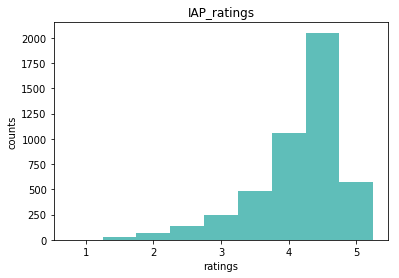

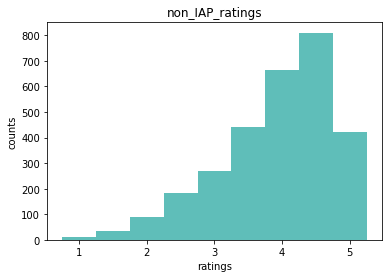

(None, None)

In [15]:
def descritized_bins(data, title, x_label, y_label):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), color = '#1BA39C', alpha=.7)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

descritized_bins(IAP_ratings,'IAP_ratings', 'ratings', 'counts'), descritized_bins(non_IAP_ratings,'non_IAP_ratings', 'ratings', 'counts')

In [16]:
str(float('nan')) == 'nan'

True

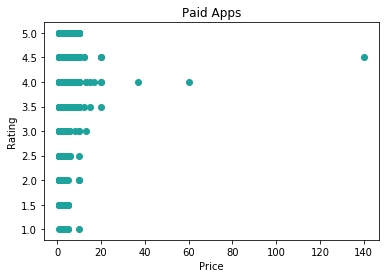

In [17]:
price = data['Price']

paid = []

for i in range(len(price)):
    if str(price[i]) != 'nan' and price[i] != 0 and str(ratings[i]) != 'nan':
        paid.append((price[i], ratings[i]))
paid_price = [i[0] for i in paid]
paid_rating = [i[1] for i in paid]

plt.scatter(paid_price, paid_rating, color = '#1BA39C')
plt.xlabel("Price")
plt.ylabel('Rating')
plt.title('Paid Apps')
plt.show()

In [73]:
rating_count = [(int(data['User Rating Count'][i]), data["Name"][i], data["ID"][i], data['Average User Rating'][i])for i in range(len(data['User Rating Count'])) if str(data['User Rating Count'][i]) != 'nan']
rating_count
most_rated = sorted(rating_count, reverse=True)[0:1000]
least_rated = sorted(rating_count)[0:100]
most_rated

[(3032734, 'Clash of Clans', 529479190, 4.5),
 (1277095, 'Clash Royale', 1053012308, 4.5),
 (711409, 'PUBG MOBILE', 1330123889, 4.5),
 (469562, 'Plants vs. Zombies\\u2122 2', 597986893, 4.5),
 (439776, 'Pok\\xe9mon GO', 1094591345, 3.5),
 (400787, 'Boom Beach', 672150402, 4.5),
 (374772, 'Cash, Inc. Fame & Fortune Game', 1270598321, 5.0),
 (283035, 'Idle Miner Tycoon: Cash Empire', 1116645064, 4.5),
 (273687, 'TapDefense', 297558390, 3.5),
 (259030, 'Star Wars\\u2122: Commander', 847985808, 4.5),
 (257852, 'Agar.io', 995999703, 4.5),
 (240990, 'Star Wars\\u2122: Galaxy of Heroes', 921022358, 4.5),
 (231877, 'Mobile Legends: Bang Bang', 1160056295, 4.5),
 (227214, 'SimCity BuildIt', 913292932, 4.5),
 (219230, 'Bloons TD Battles', 624533261, 4.5),
 (217469, 'Cooking Fever', 714796093, 4.5),
 (212763, 'Traffic Rush', 322423174, 3.5),
 (210705, '\\u22c6Spider Solitaire', 487025819, 4.5),
 (205014, 'Plague Inc.', 525818839, 4.5),
 (199585, 'Yahoo Fantasy Football & more', 328415391, 3.5),
 

In [46]:
most_rated_ID = [i[2] for i in most_rated]
most_rated_ID
unique_most_rated = count_unique(most_rated_ID, term_doc),
unique_least_rated = count_unique([i[2] for i in least_rated], term_doc)


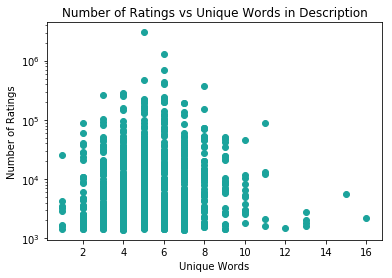

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(unique_most_rated, [i[0] for i in most_rated], color ='#1BA39C' )
ax.set_yscale('log')
ax.set_xlabel('Unique Words')
ax.set_ylabel('Number of Ratings (log scale)')
ax.set_title("Number of Ratings vs Unique Words in Description")
plt.show()

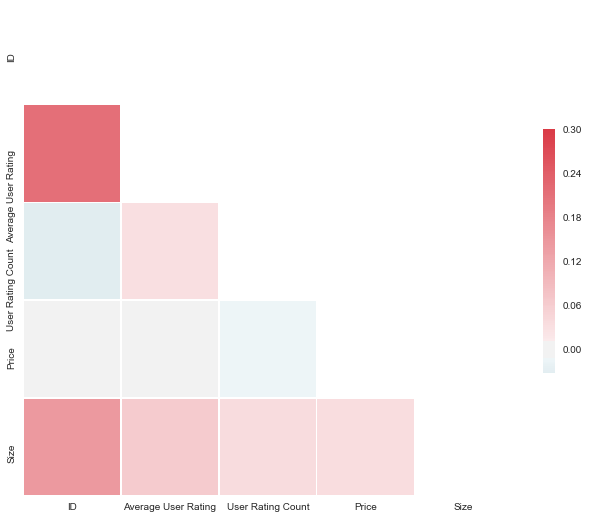

In [76]:
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()